# Driver Behavior & Route Anomalies — EDA, Visualization & Statistical Analysis

This notebook is **plug-and-play** for Kaggle.  
It will:
- Load the *Driver Behavior and Route Anomaly* dataset (DBRA24).
- Produce **publication-quality** figures (bold axis labels, large fonts, high DPI).
- Run **descriptive statistics, correlations, hypothesis tests**, and **feature relationships**.
- Explore **time-series**, **anomaly detection**, **PCA**, and **clustering**.
- Provide **interactive Plotly** charts.
- Save high-resolution figures to `./figures/`.

> **Tip:** You can run the entire notebook in order; all configuration is at the top.

## 1. Imports & Global Plot Style

In [2]:
pip install plotly

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ------ --------------------------------- 1.6/9.8 MB 16.8 MB/s eta 0:00:01
   ----------------------- ---------------- 5.8/9.8 MB 18.5 MB/s eta 0:00:01
   ---------------------------- ----------- 7.1/9.8 MB 12.8 MB/s eta 0:00:01
   --------------------------------- ------ 8.1/9.8 MB 11.2 MB/s eta 0:00:01
   ------------------------------------- -- 9.2/9.8 MB 10.4 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 9.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
import os, sys, warnings, math, gc
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, normaltest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import statsmodels.api as sm
import statsmodels.formula.api as smf

warnings.filterwarnings("ignore")

# --- High quality figure defaults ---
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("talk")  # larger fonts by default
sns.set_palette("Set2")
plt.rcParams.update({
    "figure.dpi": 160,          # High DPI
    "savefig.dpi": 300,         # Very high when saving
    "axes.labelsize": 14,
    "axes.titlesize": 18,
    "axes.labelweight": "bold",
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.autolayout": True,
})

# Helper to save figures
FIG_DIR = "./figures"
os.makedirs(FIG_DIR, exist_ok=True)

def savefig(name):
    path = os.path.join(FIG_DIR, f"{name}.png")
    plt.savefig(path, bbox_inches="tight", facecolor="white")
    print(f"Saved: {path}")

## 2. Data Paths (Kaggle & Local Friendly)
The loader tries common Kaggle input locations first and falls back to a local path.

In [5]:
from pathlib import Path

# Common Kaggle path(s) — adjust if your dataset slug differs
possible_paths = [
    Path(r"C:\Users\muroo\Downloads\Digitaltwin\Code\driver_behavior_route_anomaly_dataset_with_derived_features.csv"),
    Path(r"C:\Users\muroo\Downloads\Digitaltwin\Code\driver-behavior-and-route-anomaly-dataset-dbra24/driver_behavior_route_anomaly_dataset_with_derived_features.csv"),
]

# Local fallback (for offline runs). Replace if needed.
possible_paths.append(Path("./driver_behavior_route_anomaly_dataset_with_derived_features.csv"))

for p in possible_paths:
    if p.exists():
        DATA_PATH = p
        break
else:
    raise FileNotFoundError("Dataset CSV not found. Please place the CSV in working dir or mount the Kaggle dataset.")

DATA_PATH

WindowsPath('C:/Users/muroo/Downloads/Digitaltwin/Code/driver_behavior_route_anomaly_dataset_with_derived_features.csv')

## 3. Load Data

In [6]:
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())

Shape: (120000, 26)


,trip_id,driver_id,vehicle_id,timestamp,latitude,longitude,speed,acceleration,steering_angle,heading,...,weather_conditions,road_type,traffic_condition,stop_events,geofencing_violation,anomalous_event,route_anomaly,route_deviation_score,acceleration_variation,behavioral_consistency_index
0,1,101,1001,2023-01-01 00:00:00,38.916143,-80.345269,39.484646,3.612832,6,212.555994,...,Sunny,Urban,Light,0,0,0,0,0.176974,0.715284,0.468189
1,2,105,2002,2023-01-01 00:00:01,37.011830,-89.079516,2.795422,-0.593295,-21,134.541146,...,Sunny,Highway,Light,0,0,1,0,0.229316,0.487761,0.234935
2,3,103,2002,2023-01-01 00:00:02,33.784009,-99.103643,13.842558,-0.209264,26,116.452839,...,Cloudy,Urban,Moderate,0,0,0,0,0.473809,0.881141,0.192588
3,4,102,2002,2023-01-01 00:00:03,45.314835,-102.046210,69.121833,-0.413943,6,26.970247,...,Sunny,Highway,Moderate,3,0,0,0,0.368063,0.937918,0.363707
4,5,101,2002,2023-01-01 00:00:04,30.473386,-92.362577,13.061111,5.774122,-1,333.804023,...,Sunny,Rural,Moderate,0,0,0,0,0.145270,0.702187,0.178748


## 4. Overview & Data Quality

In [7]:
display(df.info())
display(df.describe(include='all').T)

# Missing values
mv = df.isna().sum().sort_values(ascending=False)
display(mv[mv>0])

# Basic duplicate check (by all columns)
dups = df.duplicated().sum()
print(f"Duplicate rows: {dups}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   trip_id                       120000 non-null  int64  
 1   driver_id                     120000 non-null  int64  
 2   vehicle_id                    120000 non-null  int64  
 3   timestamp                     120000 non-null  object 
 4   latitude                      120000 non-null  float64
 5   longitude                     120000 non-null  float64
 6   speed                         120000 non-null  float64
 7   acceleration                  120000 non-null  float64
 8   steering_angle                120000 non-null  int64  
 9   heading                       120000 non-null  float64
 10  trip_duration                 120000 non-null  float64
 11  trip_distance                 120000 non-null  float64
 12  fuel_consumption              120000 non-nul

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
trip_id,120000.0,NaN,NaN,NaN,60000.5,34641.160489,1.0,30000.75,60000.5,90000.25,120000.0
driver_id,120000.0,NaN,NaN,NaN,102.098875,1.371367,101.0,101.0,102.0,103.0,105.0
vehicle_id,120000.0,NaN,NaN,NaN,2106.479375,1379.539988,1001.0,1001.0,2002.0,3003.0,5005.0
timestamp,120000,120000,2023-01-01 00:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,120000.0,NaN,NaN,NaN,39.990066,5.002472,17.93057,36.623453,39.987503,43.357958,61.096832
longitude,120000.0,NaN,NaN,NaN,-90.002296,10.026103,-133.129729,-96.799608,-89.969652,-83.241541,-46.981523
speed,120000.0,NaN,NaN,NaN,29.971987,30.211853,0.000157,8.61525,20.633107,41.439832,365.764111
acceleration,120000.0,NaN,NaN,NaN,1.003904,1.998322,-0.99991,-0.41903,0.388639,1.777851,22.032532
steering_angle,120000.0,NaN,NaN,NaN,0.082442,14.87023,-45.0,-10.0,0.0,10.0,45.0
heading,120000.0,NaN,NaN,NaN,179.923038,103.833915,0.000915,89.972635,179.859502,269.673973,359.996851


Series([], dtype: int64)

Duplicate rows: 0


## 5. Identify Numeric & Categorical Columns
> Adjust the lists below if your schema differs.

In [8]:
# Simple heuristic for numeric vs categorical
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric columns:", numeric_cols[:12], "..." if len(numeric_cols)>12 else "")
print("Categorical columns:", categorical_cols)

# Common target-ish columns if present
candidate_targets = [c for c in df.columns if "anomaly" in c.lower() or "anomalous" in c.lower()]
print("Potential targets:", candidate_targets)

Numeric columns: ['trip_id', 'driver_id', 'vehicle_id', 'latitude', 'longitude', 'speed', 'acceleration', 'steering_angle', 'heading', 'trip_duration', 'trip_distance', 'fuel_consumption'] ...
Categorical columns: ['timestamp', 'weather_conditions', 'road_type', 'traffic_condition']
Potential targets: ['anomalous_event', 'route_anomaly']


## 6. Distributions (Numeric)

Saved: ./figures\dist_trip_id.png


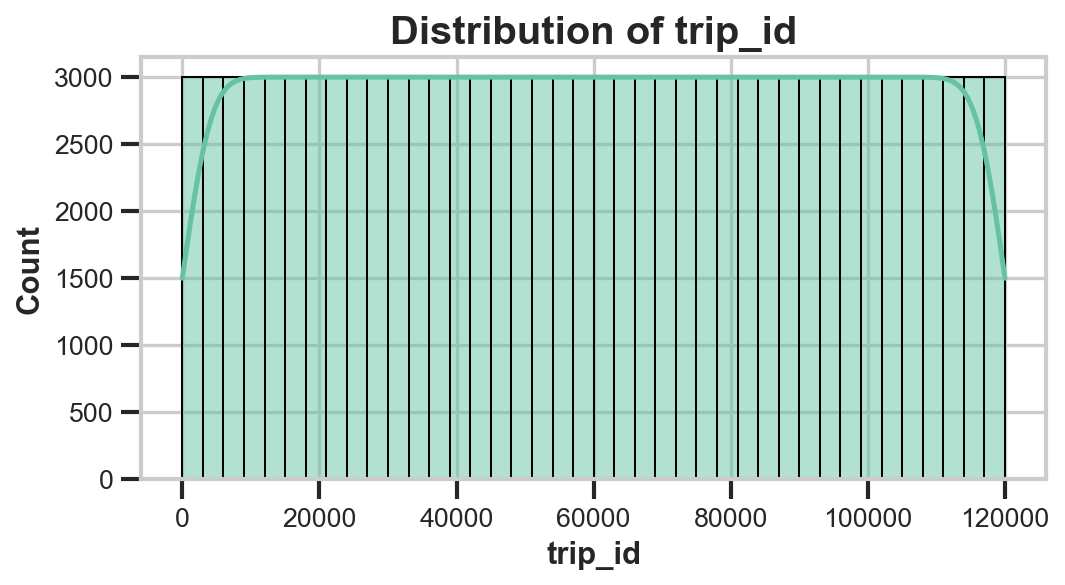

Saved: ./figures\dist_driver_id.png


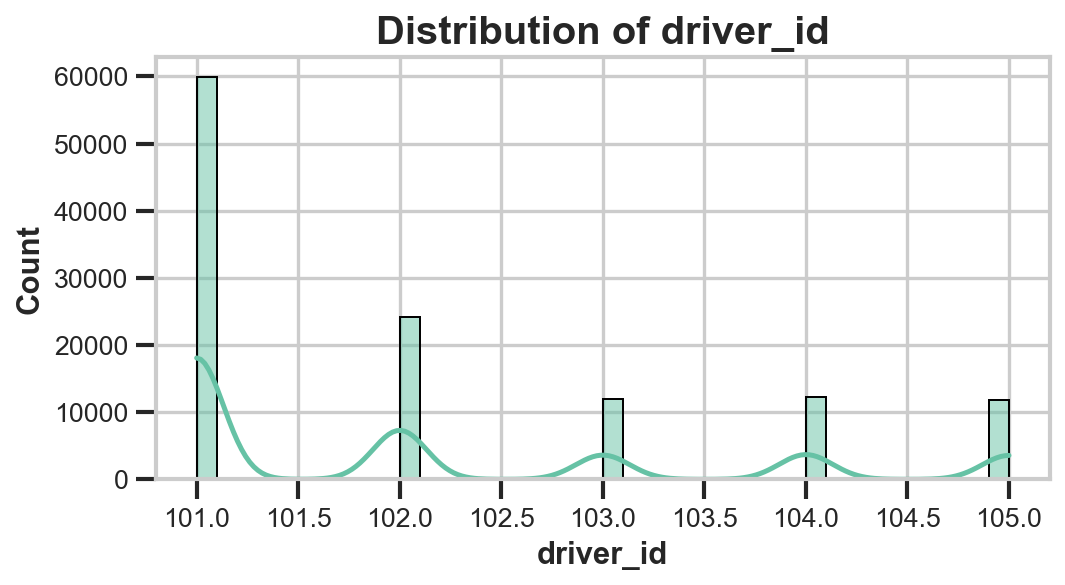

Saved: ./figures\dist_vehicle_id.png


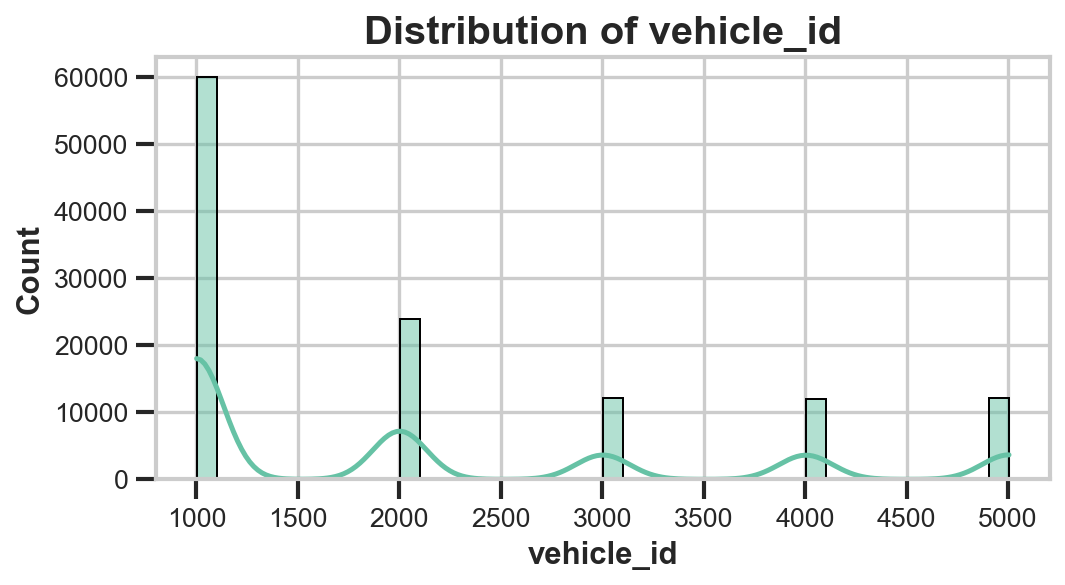

Saved: ./figures\dist_latitude.png


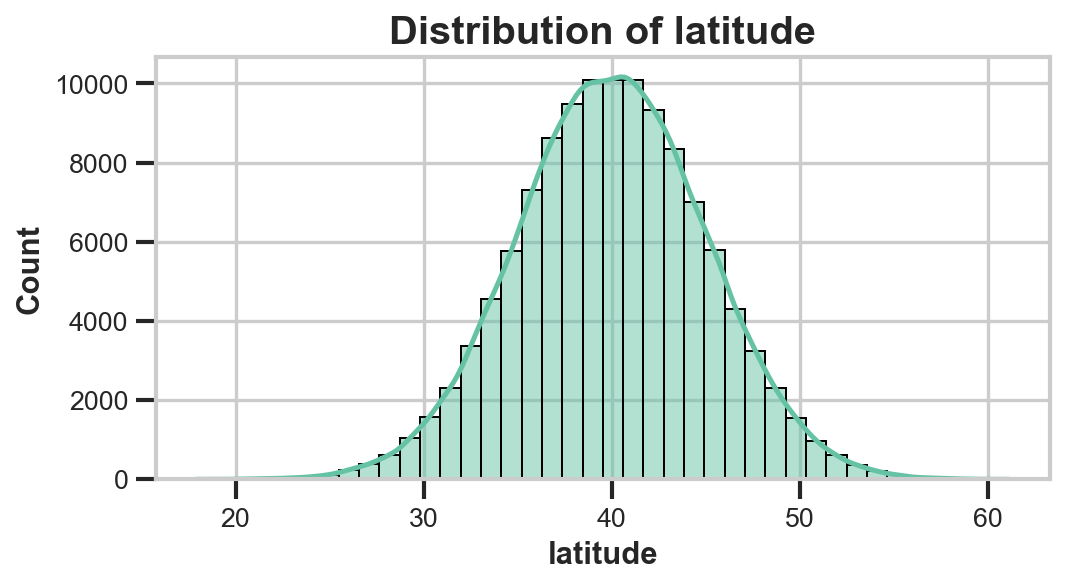

Saved: ./figures\dist_longitude.png


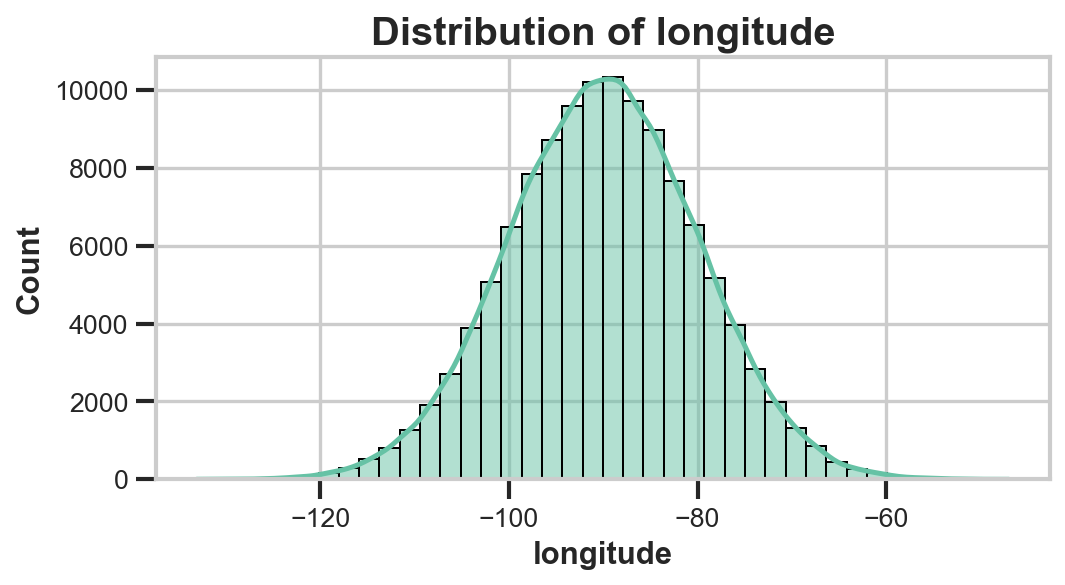

Saved: ./figures\dist_speed.png


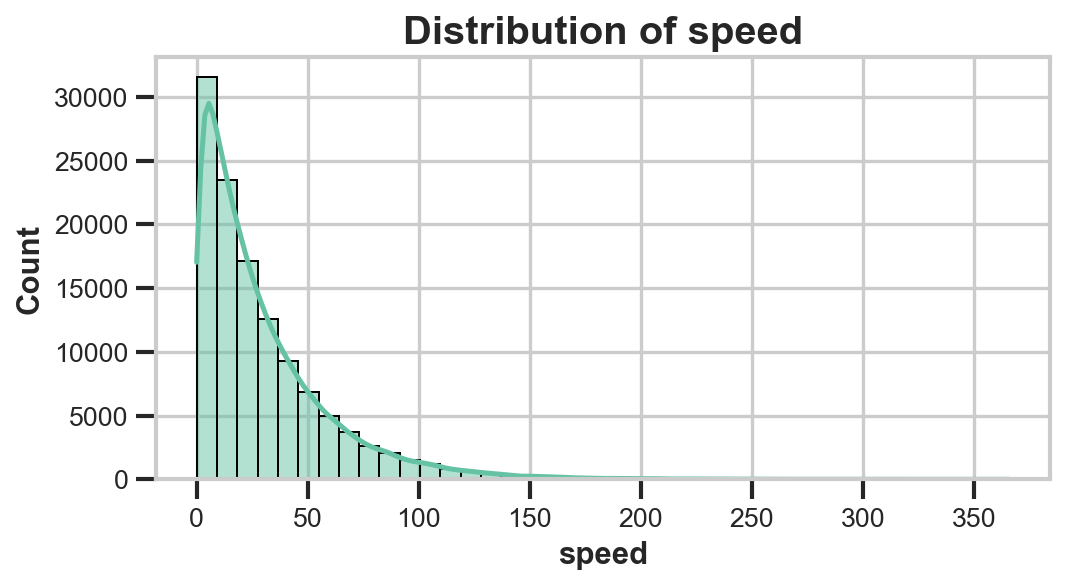

Saved: ./figures\dist_acceleration.png


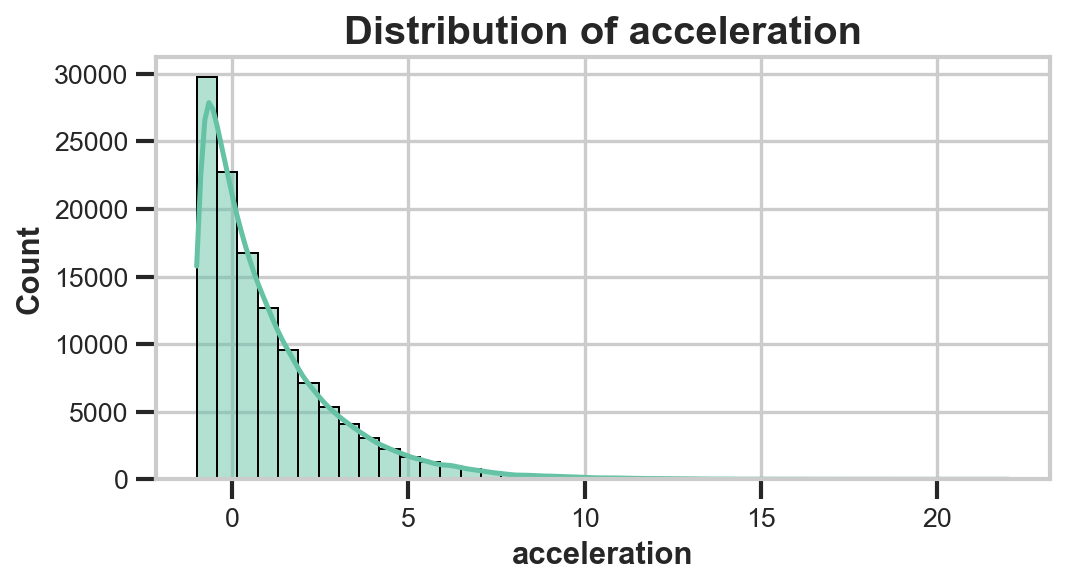

Saved: ./figures\dist_steering_angle.png


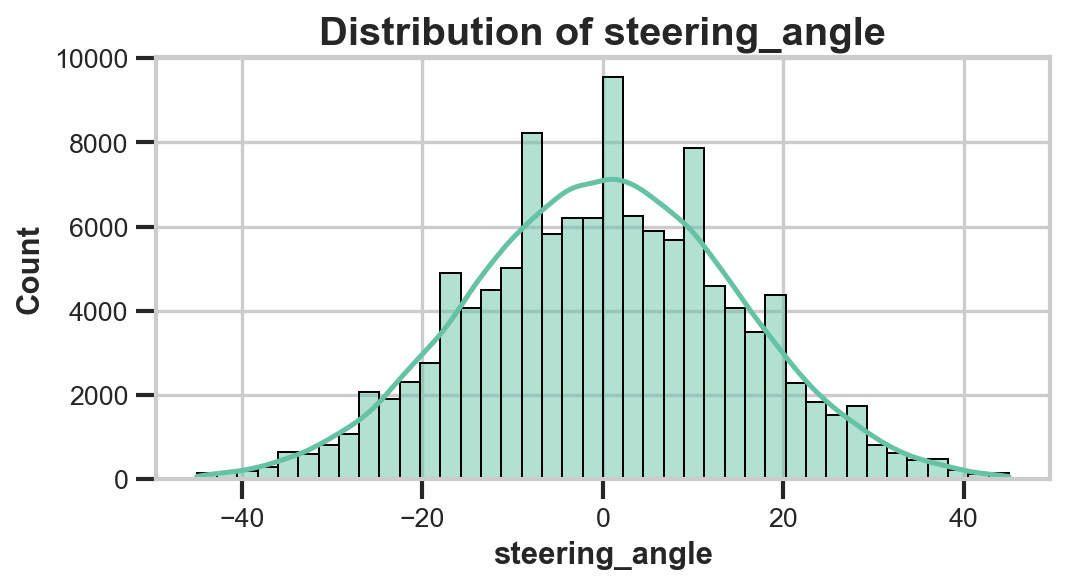

Saved: ./figures\dist_heading.png


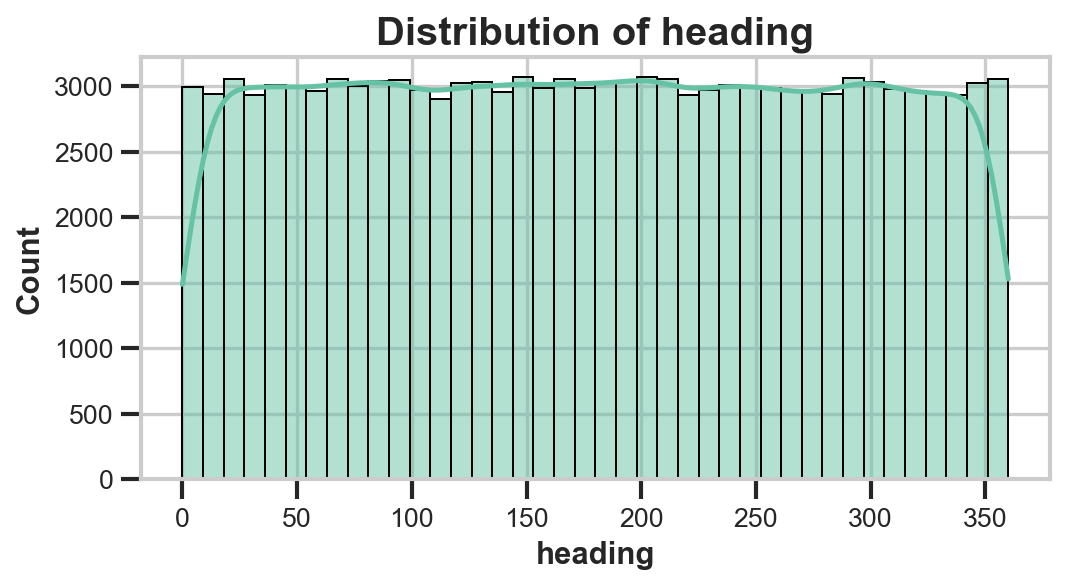

Saved: ./figures\dist_trip_duration.png


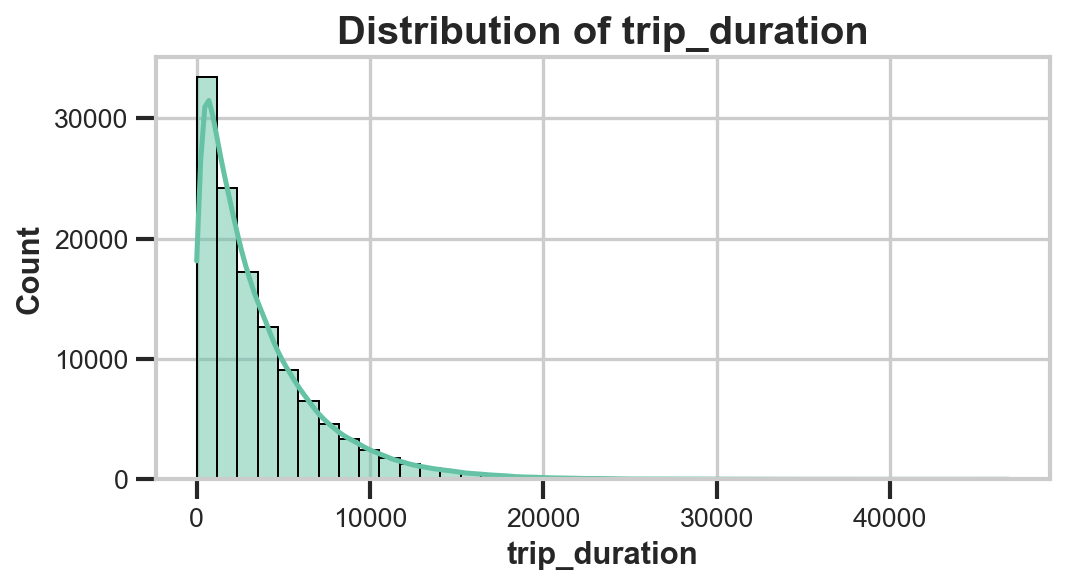

Saved: ./figures\dist_trip_distance.png


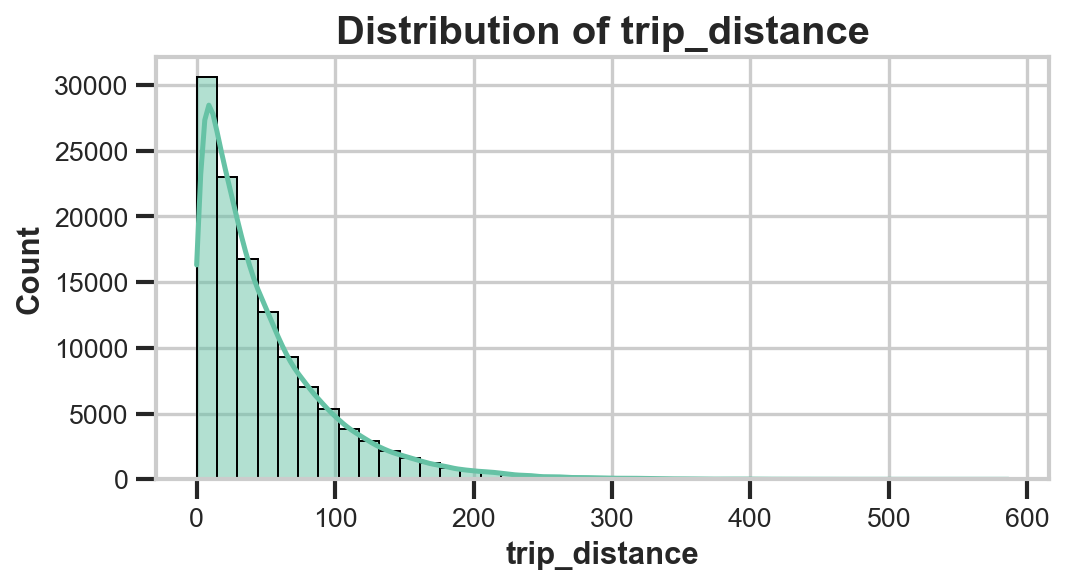

Saved: ./figures\dist_fuel_consumption.png


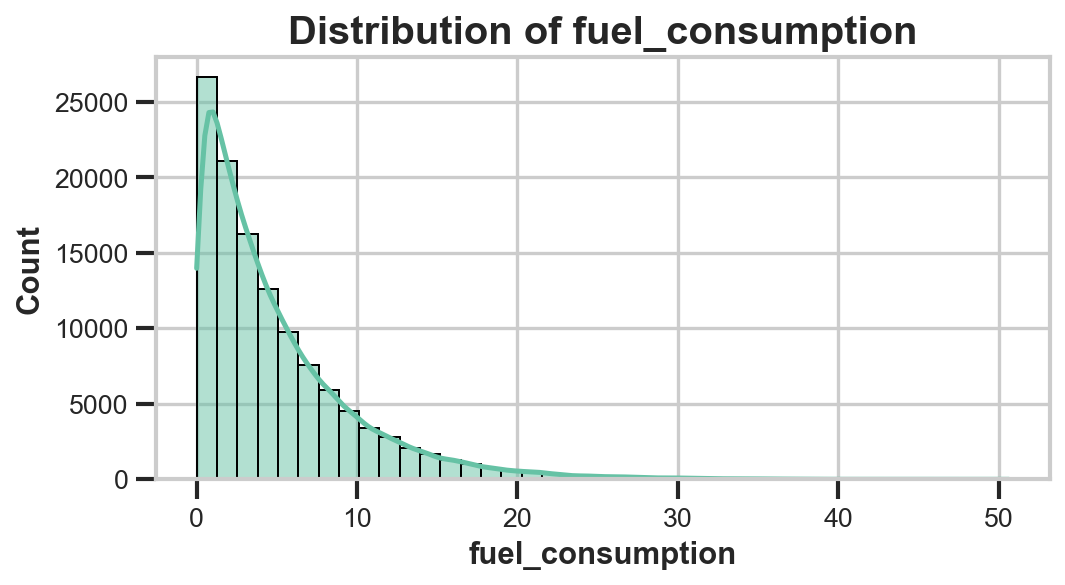

Saved: ./figures\dist_rpm.png


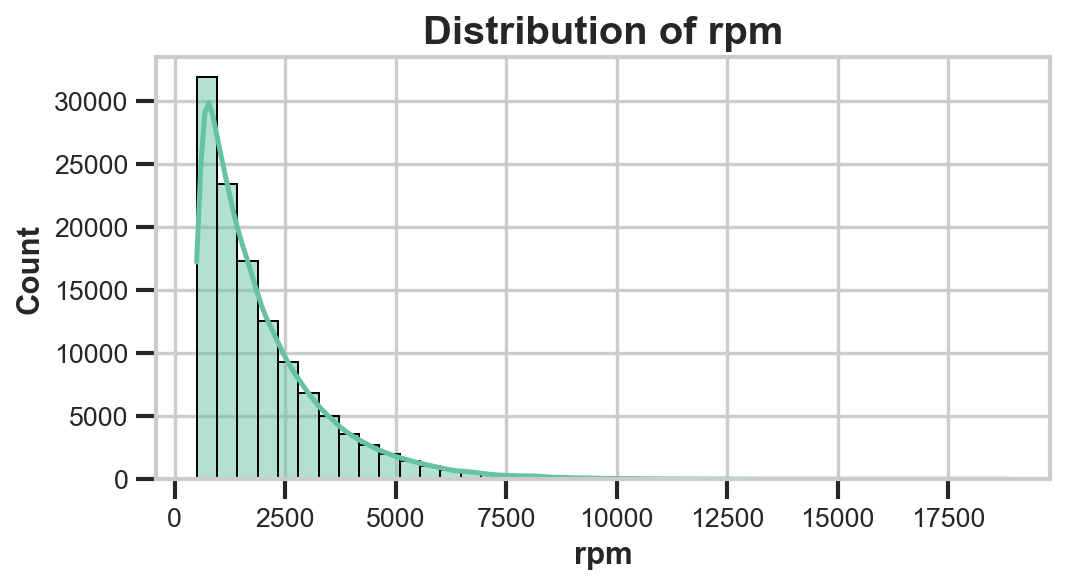

Saved: ./figures\dist_brake_usage.png


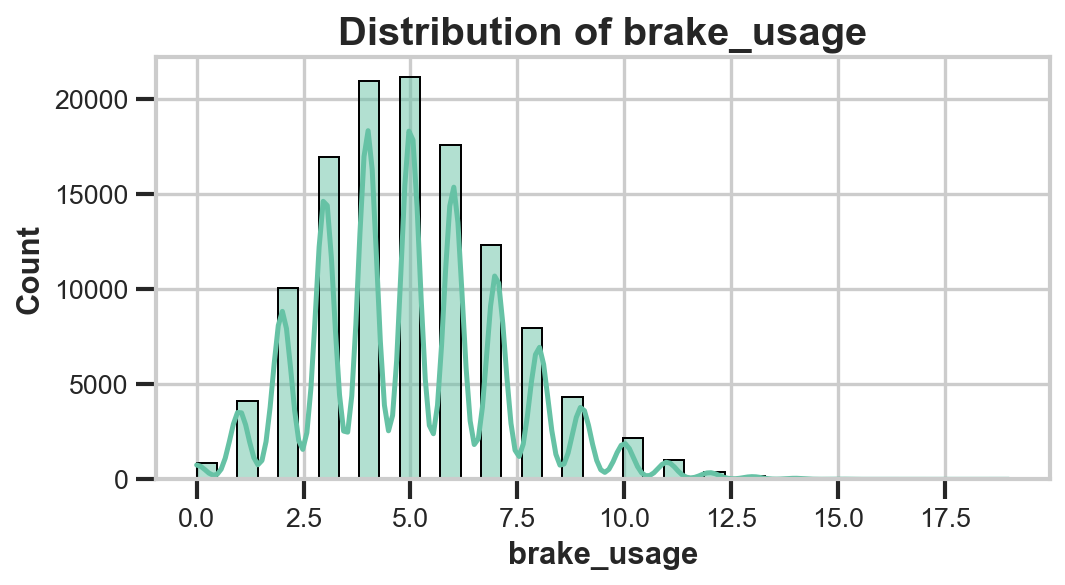

Saved: ./figures\dist_lane_deviation.png


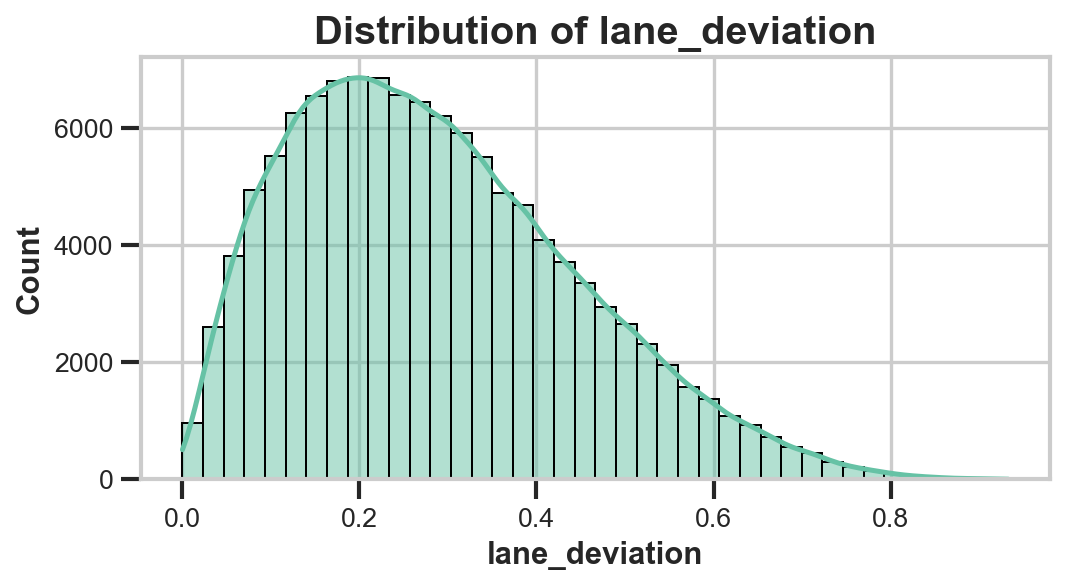

Saved: ./figures\dist_stop_events.png


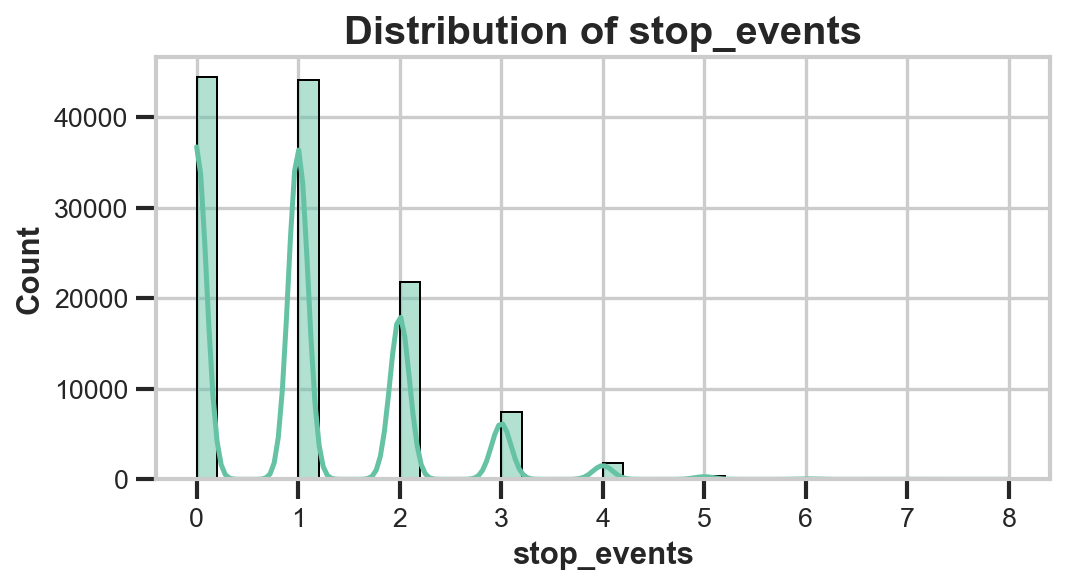

Saved: ./figures\dist_geofencing_violation.png


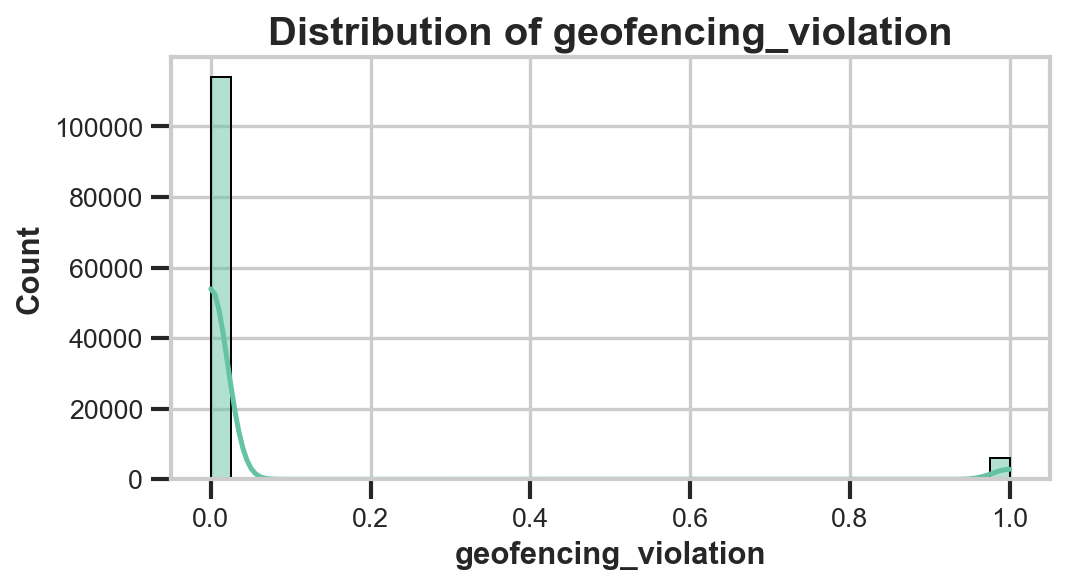

Saved: ./figures\dist_anomalous_event.png


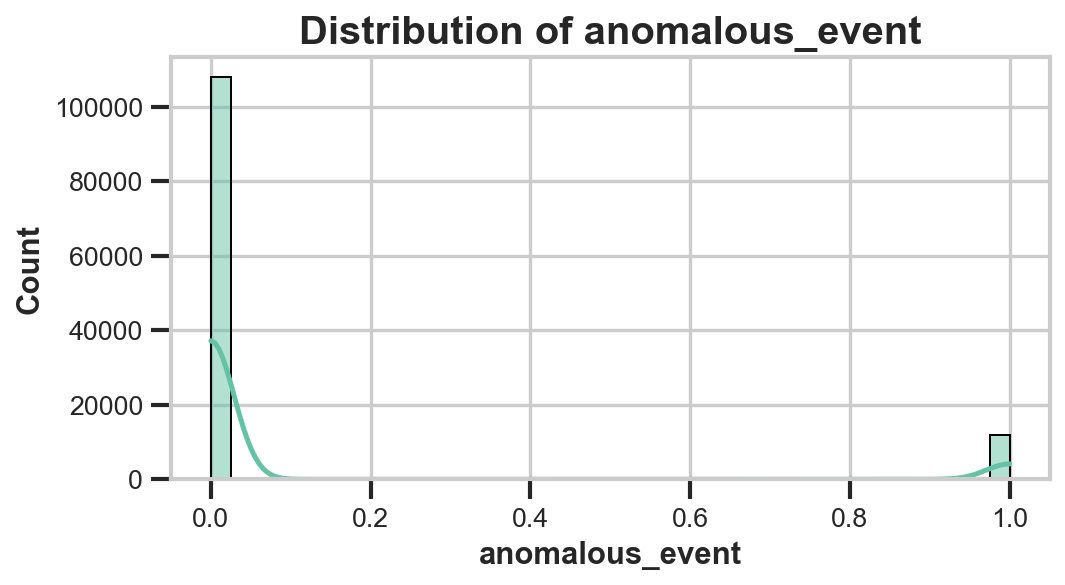

Saved: ./figures\dist_route_anomaly.png


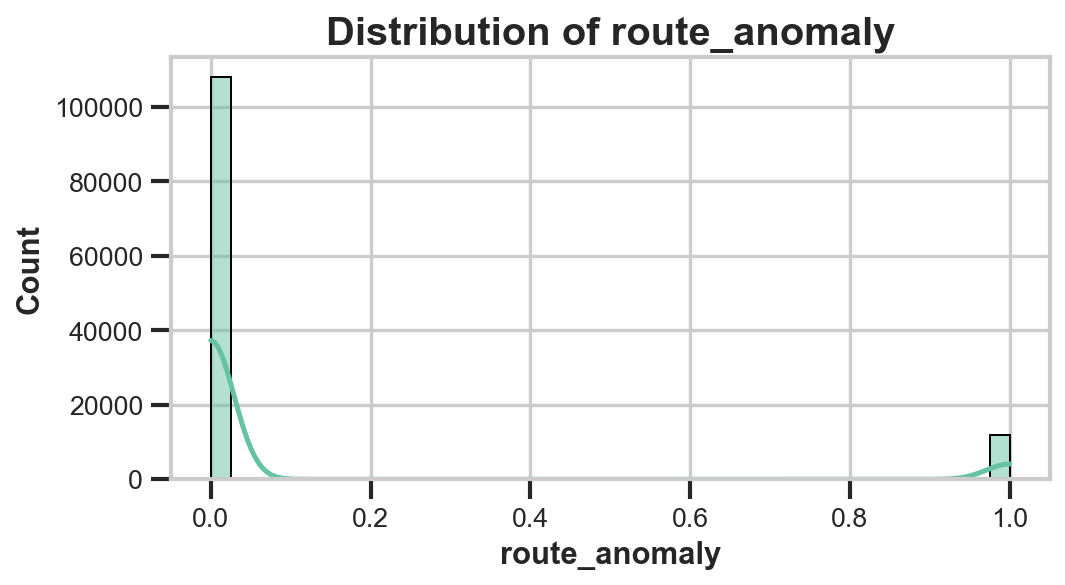

Saved: ./figures\dist_route_deviation_score.png


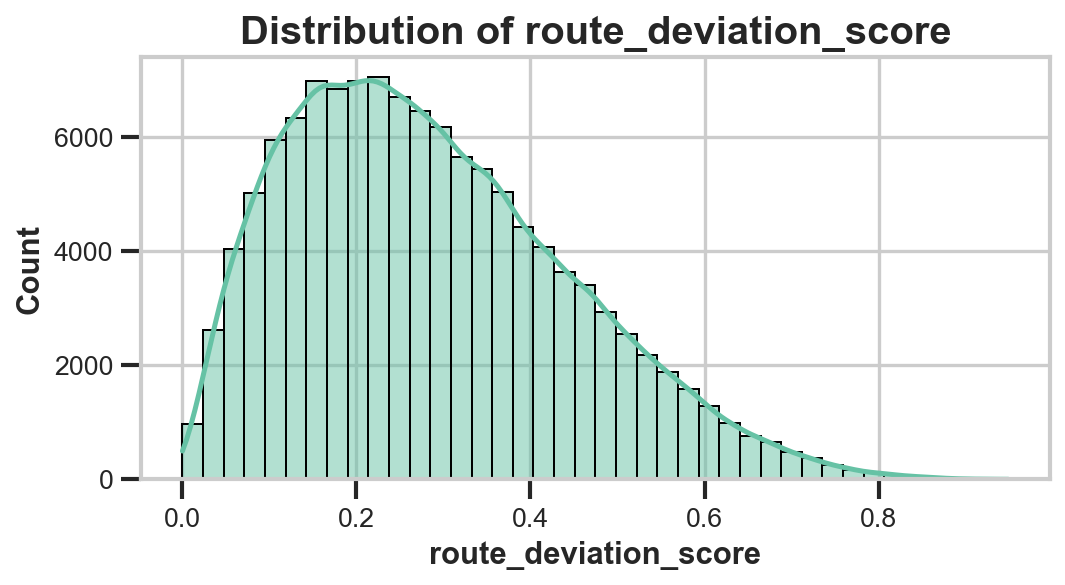

Saved: ./figures\dist_acceleration_variation.png


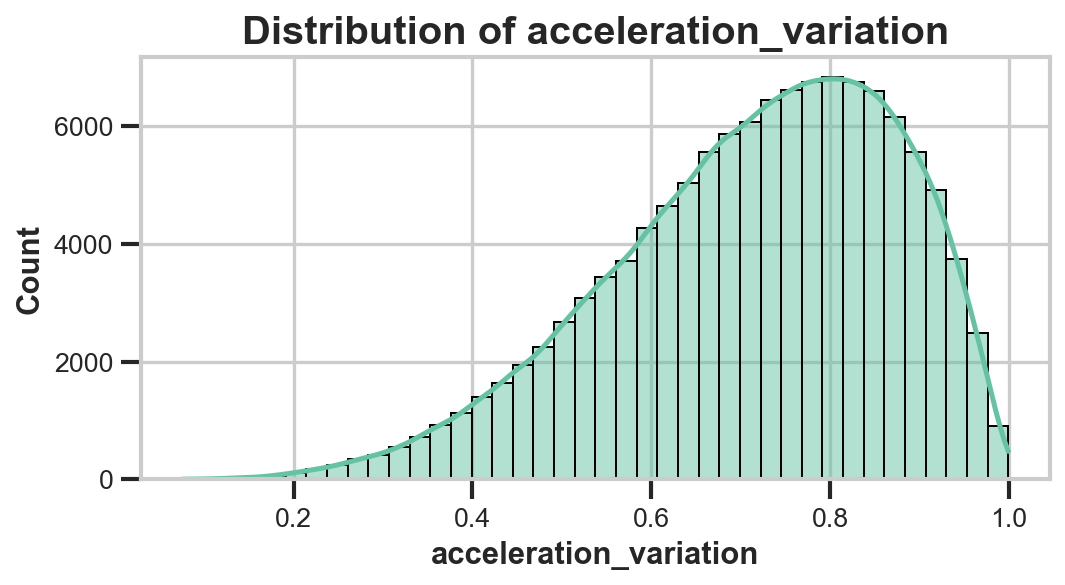

Saved: ./figures\dist_behavioral_consistency_index.png


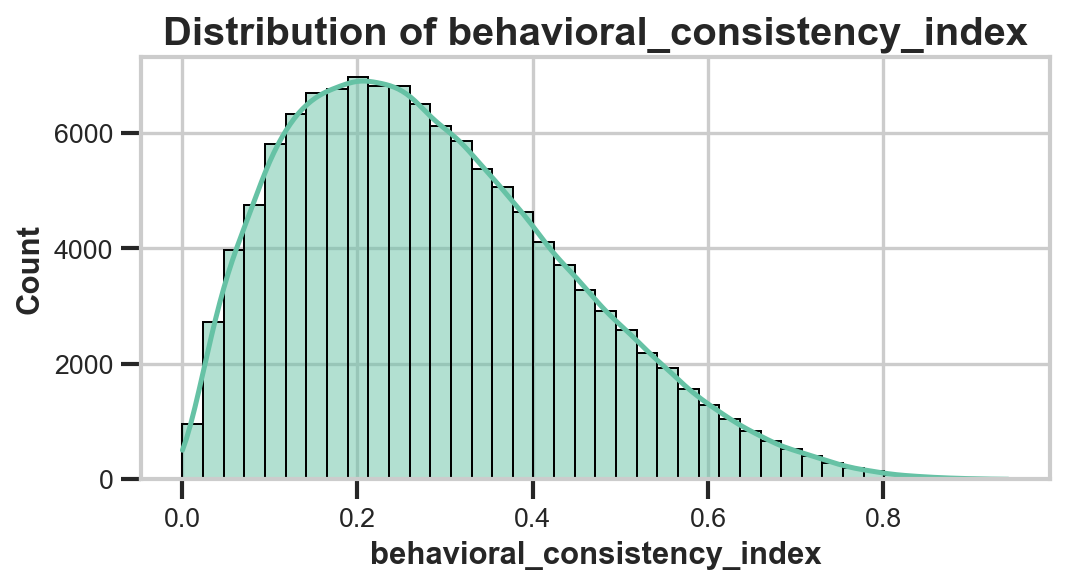

In [9]:
for col in numeric_cols:
    plt.figure(figsize=(7,4))
    sns.histplot(df[col].dropna(), bins=40, kde=True)
    plt.title(f"Distribution of {col}", fontweight="bold")
    plt.xlabel(col, fontweight="bold")
    plt.ylabel("Count", fontweight="bold")
    savefig(f"dist_{col}")
    plt.show()

## 8. Correlation Heatmap (Numeric)

In [ ]:
if len(numeric_cols) >= 2:
    plt.figure(figsize=(min(0.7*len(numeric_cols)+6, 20), min(0.7*len(numeric_cols)+6, 20)))
    corr = df[numeric_cols].corr()
    sns.heatmap(corr, cmap="coolwarm", annot=len(numeric_cols) <= 12, fmt=".2f", square=False)
    plt.title("Correlation Heatmap", fontweight="bold")
    savefig("correlation_heatmap")
    plt.show()

## 9. Bivariate Relationships
- Numeric vs numeric: pairplot (sampled for speed).
- Numeric vs categorical target (if exists): box/violin plots.

In [ ]:
# Pairplot on a sample to keep it fast
sample = df.sample(min(len(df), 2000), random_state=42)
cols_for_pair = numeric_cols[:6]  # limit
if len(cols_for_pair) >= 2:
    g = sns.pairplot(sample[cols_for_pair], diag_kind="kde", corner=True)
    g.fig.suptitle("Pairplot (sampled)", y=1.02, fontweight="bold")
    g.savefig(os.path.join(FIG_DIR, "pairplot.png"), dpi=300)

# If target-like column exists, show distribution of a few numeric features by that label
target = candidate_targets[0] if candidate_targets else None
if target and target in df.columns:
    for col in numeric_cols[:6]:
        plt.figure(figsize=(7,4))
        sns.boxplot(x=target, y=col, data=df, showfliers=False)
        plt.title(f"{col} by {target}", fontweight="bold")
        plt.xlabel(str(target), fontweight="bold")
        plt.ylabel(str(col), fontweight="bold")
        savefig(f"by_{target}_{col}")
        plt.show()

## 10. Hypothesis Testing
Example: compare mean `speed` between anomaly vs non-anomaly groups using **t-test** (and fallback Mann–Whitney if not normal).

In [ ]:
def group_test(x, y, label_x="Group A", label_y="Group B"):
    x = pd.Series(x).dropna()
    y = pd.Series(y).dropna()
    # Normality checks (D'Agostino K^2)
    nx = normaltest(x).pvalue if len(x) > 7 else 0
    ny = normaltest(y).pvalue if len(y) > 7 else 0
    if nx > 0.05 and ny > 0.05:
        stat, p = ttest_ind(x, y, equal_var=False)
        method = "Welch's t-test"
    else:
        stat, p = mannwhitneyu(x, y, alternative="two-sided")
        method = "Mann–Whitney U"
    return method, stat, p

target = candidate_targets[0] if candidate_targets else None
example_feature = "speed" if "speed" in df.columns else (numeric_cols[0] if numeric_cols else None)

if target and example_feature:
    x = df.loc[df[target]==1, example_feature]
    y = df.loc[df[target]==0, example_feature]
    method, stat, p = group_test(x, y, "anomaly=1", "anomaly=0")
    print(f"{method} on {example_feature} by {target}: stat={stat:.3f}, p={p:.4f}")
else:
    print("No suitable target/feature found for the demo test. Adjust 'example_feature'.")

## 11. Simple Regression (OLS)
Estimate how a numeric outcome depends on others. Adjust the formula to suit your data.

In [ ]:
# Build a small OLS if at least 2 numeric features exist
if len(numeric_cols) >= 2:
    y = numeric_cols[0]
    x_vars = numeric_cols[1:4]
    formula = y + " ~ " + " + ".join(x_vars)
    print("Formula:", formula)
    model = smf.ols(formula=formula, data=df.dropna(subset=[y]+x_vars)).fit()
    print(model.summary())
else:
    print("Not enough numeric columns for OLS.")

## 12. Time-Series Glance (if timestamp & trip available)

In [ ]:
time_col_candidates = [c for c in df.columns if "time" in c.lower() or "timestamp" in c.lower() or "date" in c.lower()]
trip_col_candidates = [c for c in df.columns if "trip" in c.lower() or "session" in c.lower() or "ride" in c.lower()]

if time_col_candidates and trip_col_candidates:
    tcol = time_col_candidates[0]
    trcol = trip_col_candidates[0]
    df_ts = df[[tcol, trcol, *[c for c in ["speed","acceleration","rpm","steering_angle"] if c in df.columns]]].dropna()
    try:
        df_ts[tcol] = pd.to_datetime(df_ts[tcol])
        # Pick a short trip
        sample_trip = df_ts[trcol].mode().iloc[0]
        sub = df_ts[df_ts[trcol]==sample_trip].sort_values(tcol).head(2000)
        plt.figure(figsize=(12,4))
        if "speed" in sub.columns:
            plt.plot(sub[tcol], sub["speed"], label="speed")
        if "acceleration" in sub.columns:
            plt.plot(sub[tcol], sub["acceleration"], label="acceleration")
        plt.title(f"Time Series — {trcol}={sample_trip}", fontweight="bold")
        plt.xlabel(tcol, fontweight="bold")
        plt.ylabel("Value", fontweight="bold")
        plt.legend()
        savefig("timeseries_sample")
        plt.show()
    except Exception as e:
        print("Time parsing failed:", e)
else:
    print("Timestamp/trip columns not found — skipping TS demo.")

## 13. PCA (Dimensionality Reduction)

In [ ]:
# Only on numeric columns without NaN
data_num = df[numeric_cols].dropna()
if data_num.shape[1] >= 2 and len(data_num) >= 10:
    scaler = StandardScaler()
    Xs = scaler.fit_transform(data_num)
    pca = PCA(n_components=2, random_state=42)
    comps = pca.fit_transform(Xs)
    pca_df = pd.DataFrame(comps, columns=["PC1","PC2"], index=data_num.index)
    color = candidate_targets[0] if candidate_targets else None
    plt.figure(figsize=(7,5))
    if color and color in df.columns:
        sns.scatterplot(x=pca_df["PC1"], y=pca_df["PC2"], hue=df.loc[pca_df.index, color], alpha=0.7)
        plt.legend(title=color)
    else:
        sns.scatterplot(x=pca_df["PC1"], y=pca_df["PC2"], alpha=0.7)
    plt.title("PCA (2 components)", fontweight="bold")
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)", fontweight="bold")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)", fontweight="bold")
    savefig("pca_scatter")
    plt.show()
else:
    print("PCA skipped (insufficient numeric data).")

## 14. KMeans Clustering (k=3 demo)

In [ ]:
data_num = df[numeric_cols].dropna()
if data_num.shape[1] >= 2 and len(data_num) >= 50:
    scaler = StandardScaler()
    Xs = scaler.fit_transform(data_num)
    km = KMeans(n_clusters=3, random_state=42, n_init=10)
    labels = km.fit_predict(Xs)
    df_k = pd.DataFrame({"cluster": labels}, index=data_num.index)
    # Visualize via PCA for 2D
    pca = PCA(n_components=2, random_state=42)
    comps = pca.fit_transform(Xs)
    comp_df = pd.DataFrame(comps, columns=["PC1","PC2"], index=data_num.index)
    plt.figure(figsize=(7,5))
    sns.scatterplot(x=comp_df["PC1"], y=comp_df["PC2"], hue=df_k["cluster"], alpha=0.75, palette="Set1")
    plt.title("KMeans clusters (PCA projection)", fontweight="bold")
    plt.xlabel("PC1", fontweight="bold"); plt.ylabel("PC2", fontweight="bold")
    savefig("kmeans_pca")
    plt.show()
else:
    print("Clustering skipped (insufficient data).")

## 15. Anomaly Detection (Isolation Forest & LOF)

In [ ]:
data_num = df[numeric_cols].dropna()
if data_num.shape[1] >= 2 and len(data_num) >= 50:
    scaler = StandardScaler()
    Xs = scaler.fit_transform(data_num)

    iso = IsolationForest(contamination=0.02, random_state=42)
    iso_labels = iso.fit_predict(Xs)  # -1 = anomaly, 1 = normal
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
    lof_labels = lof.fit_predict(Xs)

    df_an = pd.DataFrame({
        "iso_outlier": (iso_labels==-1).astype(int),
        "lof_outlier": (lof_labels==-1).astype(int)
    }, index=data_num.index)

    print(df_an.mean().to_frame("rate").T)

    # Visualize (PCA projection)
    pca = PCA(n_components=2, random_state=42)
    comps = pca.fit_transform(Xs)
    comp_df = pd.DataFrame(comps, columns=["PC1","PC2"], index=data_num.index)

    for col in ["iso_outlier", "lof_outlier"]:
        plt.figure(figsize=(7,5))
        sns.scatterplot(x=comp_df["PC1"], y=comp_df["PC2"], hue=df_an[col], palette="Set1", alpha=0.8)
        plt.title(f"Anomaly flag: {col}", fontweight="bold")
        plt.xlabel("PC1", fontweight="bold"); plt.ylabel("PC2", fontweight="bold")
        savefig(f"{col}_pca")
        plt.show()
else:
    print("Anomaly detection skipped (insufficient data).")

## 16. Interactive Plotly Examples

In [ ]:
disp_cols = [c for c in ["speed","acceleration","rpm","steering_angle"] if c in df.columns]
if len(disp_cols) >= 2:
    fig = px.scatter(df.sample(min(len(df), 5000), random_state=42),
                     x=disp_cols[0], y=disp_cols[1],
                     color=candidate_targets[0] if candidate_targets else None,
                     title="Interactive Scatter", opacity=0.7)
    fig.show()
else:
    print("Not enough numeric columns for interactive demo.")

## 17. Export Cleaned Subset (Optional)
This creates a trimmed CSV for fast prototyping.

In [ ]:
out_cols = numeric_cols[:10] + candidate_targets[:1]
out_cols = [c for c in out_cols if c in df.columns]
if out_cols:
    slim = df[out_cols].dropna().head(20000)
    slim.to_csv("dbra24_slim.csv", index=False)
    print("Saved dbra24_slim.csv with shape", slim.shape)
else:
    print("No suitable columns to export.")

---

### ✅ Notebook Complete
- All figures saved to `./figures/` at **300 DPI**.
- Tweak palettes or fonts via the style block at the top.
- For publication: use the PNGs, or switch `savefig()` to PDF/SVG.

**Good luck, and happy modeling!**